In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import ta
import pickle
from gym_anytrading.envs import StocksEnv,Actions,Positions
from stable_baselines3 import PPO, A2C
from sb3_contrib import RecurrentPPO
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [29]:
!pip install numpy==2.1.0

In [30]:
window_size = 20
start_date = '2024-01-01'
today = datetime.today().date()
end_date = today.strftime("%Y-%m-%d")

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('columns_to_scale.pkl', 'rb') as f:
    columns_to_scale = pickle.load(f)

# 1. Custom Environment

In [31]:
class CustomStocksEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound, render_mode=None):
        super().__init__(df, window_size, frame_bound, render_mode)

        self.trade_fee_bid_percent = 0.001  # unit
        self.trade_fee_ask_percent = 0.001

    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
        signal_features = self.df.drop(['Close'],axis=1).to_numpy()[start:end]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff, signal_features))

        close_col_idx = self.df.columns.get_loc('Close')
        close_mean = scaler.mean_[close_col_idx]
        close_scale = scaler.scale_[close_col_idx]
        # invert scaling
        prices = prices * close_scale + close_mean

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


In [32]:
def load_data(ticker):
    stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')

    df = stock_data.reset_index()#[['Date','Close']]

    df.sort_values(by=['Date'], inplace=True)

    data = df.copy()

    # Calculate Simple Moving Average (SMA)
    data['sma'] = ta.trend.sma_indicator(data['Close'], window=10)

    # Calculate Exponential Moving Average (EMA)
    data['ema'] = ta.trend.ema_indicator(data['Close'], window=10)

    # Calculate Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()

    # Calculate Stochastic Oscillator
    stochastic_osc = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=10, smooth_window=3)
    data['stoch'] = stochastic_osc.stoch()
    data['stoch'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
    data['stoch_signal'] = stochastic_osc.stoch_signal()

    # Calculate Relative Strength Index (RSI)
    data['rsi'] = ta.momentum.rsi(data['Close'], window=10)

    # Calculate Average True Range (ATR)
    data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=10)

    # Calculate Accumulation Distribution Index (ADI)
    data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Close'], data['Volume'])
    data['adi'].replace([np.inf, -np.inf], 0, inplace=True)

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_mavg'] = bollinger.bollinger_mavg()

    #Commodity Channel Index (CCI)
    data['cci'] = ta.trend.cci(data['High'], data['Low'], data['Close'], window=20)

    # Aroon Indicator
    aroon = ta.trend.AroonIndicator(high=data['High'], low=data['Low'], window=25)
    data['aroon_up'] = aroon.aroon_up()
    data['aroon_down'] = aroon.aroon_down()

    # Williams %R
    data['williams_r'] = ta.momentum.williams_r(data['High'], data['Low'], data['Close'], lbp=10)
    data['williams_r'].replace([-float('inf'), float('inf')], np.nan, inplace=True)


    # Money Flow Index (MFI)
    data['mfi'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], window=10)

    # Rate of Change (ROC)
    data['roc'] = ta.momentum.roc(data['Close'], window=10)

    # Chaikin A/D Line
    data['chaikin_ad'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume'], window=20).chaikin_money_flow()

    # On-Balance Volume (OBV)
    data['obv'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])

    #Remove null values and unecessary columns
    data = data.dropna()
    data.drop(['Dividends','Stock Splits'],axis=1, inplace=True)

    #Scaling
    data[columns_to_scale] = scaler.transform(data[columns_to_scale])
    data.set_index('Date', inplace=True)

    return data

def make_pred(df,model_type,window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path =  './best_model'
    elif model_type == 'RecurrentPPO':
        model_path =  './best_model_ltsm'
    elif model_type == 'A2C':
        model_path =  './best_model_a2c'
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None

    final_model = PPO.load(model_path)

    obs, info = test_env.reset()
    rewards = []
    while True:
        action, _states = final_model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        if done:
            print("Final info:", info)
            break

    plt.figure(figsize=(15, 6))
    plt.cla()
    test_env.unwrapped.render_all()
    #plt.savefig(f"predictions_{model_type}.pdf")  ## Save fig
    plt.show()
    test_env.close()

# 2. Make Predictions

In [33]:
df = load_data('AMD') #All models result in loss
#df = load_data('INTC') #Some still profit even the stock price is decreasing
#df = load_data('AVGO') #All models profit but not better than holding all the time
#df = load_data('ARM') #RecurrentPPO beats the market with 228% profit


In [35]:
df

,Open,High,Low,Close,Volume,sma,ema,macd,macd_signal,macd_diff,...,bollinger_lband,bollinger_mavg,cci,aroon_up,aroon_down,williams_r,mfi,roc,chaikin_ad,obv
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-20 00:00:00-05:00,15.199524,14.988924,14.607746,14.687102,-2.096888,15.535724,15.597918,4.679150,6.553172,-5.361043,...,16.862841,15.949405,-1.395440,-0.761941,-1.070286,-1.232561,-0.283564,-0.711904,0.012348,-2.254112
2024-02-21 00:00:00-05:00,14.355617,14.305604,14.588276,14.546105,-2.189049,15.499086,15.453132,3.583402,5.999638,-7.385273,...,16.766295,15.927976,-1.759301,-0.873415,-1.070286,-1.452675,-0.177728,-0.448983,-0.040468,-2.259148
2024-02-22 00:00:00-05:00,15.406482,16.177566,15.632478,16.315618,-1.919908,15.610530,15.661648,4.358007,5.720682,-3.713659,...,16.724900,15.946500,0.687456,-0.984888,-1.070286,1.111620,0.058421,0.362359,-0.037513,-2.248752
2024-02-23 00:00:00-05:00,16.276510,16.174599,15.893785,15.777815,-2.083110,15.683703,15.732875,4.401216,5.506658,-2.845397,...,16.753366,15.926730,0.588115,-1.096362,-1.070286,0.312157,-0.082405,0.157363,-0.053477,-2.255898
2024-02-26 00:00:00-05:00,15.967078,15.783000,15.920428,15.726451,-2.206364,15.719728,15.781660,4.332173,5.320833,-2.468333,...,16.757895,15.920296,0.373161,-1.207836,1.433469,0.235802,-0.544730,-0.050759,-0.089368,-2.260589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05 00:00:00-05:00,8.816973,9.083296,8.920485,9.280875,-1.869613,9.962319,9.955609,-3.899613,-4.045081,-0.266874,...,10.738275,10.315168,-1.862477,-0.984888,1.774890,-0.921332,-0.987790,-1.148213,0.270998,-2.332383
2025-02-06 00:00:00-05:00,9.150517,9.129774,9.178717,9.094557,-2.180484,9.830873,9.829342,-4.326410,-4.152325,-1.417557,...,10.655602,10.226076,-1.696027,-1.096362,1.661083,-1.246603,-0.541206,-1.241585,0.380123,-2.337589
2025-02-07 00:00:00-05:00,8.969679,8.868708,8.950202,8.832705,-2.203007,9.674934,9.677647,-4.863829,-4.351814,-2.651040,...,10.453544,10.151980,-1.934555,-1.207836,1.547276,-1.639435,-0.953231,-1.429115,0.312657,-2.342347


In [34]:
# PPO
make_pred(df,'PPO')

ValueError: <class 'numpy.random._pcg64.PCG64'> is not a known BitGenerator module.

In [20]:
#RecurrentPPO
make_pred(df,'RecurrentPPO')

FileNotFoundError: [Errno 2] No such file or directory: 'best_model_ltsm.zip.zip'

Final info: {'total_reward': np.float32(-5.369995), 'total_profit': np.float32(0.9606687), 'position': <Positions.Short: 0>}


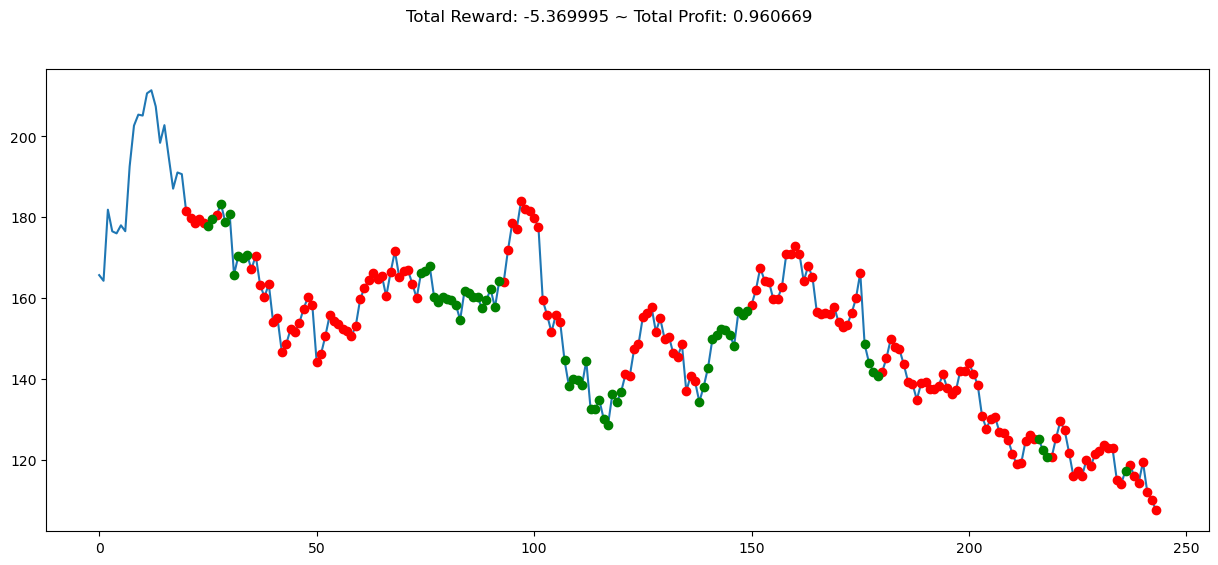

In [ ]:
#A2C
make_pred(df,'A2C')

# 3. Compare Performance(Uptrend, Downtrend, Sideways Trend)

In [36]:
def make_pred(df, model_type, window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path = './logs/best_model/best_model.zip'
    elif model_type == 'RecurrentPPO':
        model_path = './logs/best_model_lstm/best_model.zip'
    elif model_type == 'A2C':
        model_path = './logs/best_model_a2c/best_model.zip'
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None

    final_model = PPO.load(model_path)

    obs, info = test_env.reset()
    final_info = None  # Variable to store final info

    while True:
        action, _states = final_model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = test_env.step(action)

        if terminated or truncated:
            final_info = info  # Store the final info
            break

    test_env.close()

    return final_info  # Return extracted info

def compute_buy_hold(df):
    initial_price = df.iloc[0]['Close']
    final_price = df.iloc[-1]['Close']

    total_profit = final_price / initial_price
    total_reward = total_profit - 1

    return total_reward, total_profit

def moving_average_crossover(df, short_window=10, long_window=50):
    """Compute Moving Average Crossover strategy."""
    df = df.copy()
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    df['Position'] = 0
    df.loc[df['Short_MA'] > df['Long_MA'], 'Position'] = 1  # Buy
    df.loc[df['Short_MA'] < df['Long_MA'], 'Position'] = -1  # Sell

    df['Daily_Return'] = df['Close'].pct_change() * df['Position'].shift(1)
    total_profit = (df['Daily_Return'] + 1).cumprod().iloc[-1]
    total_reward = total_profit - 1

    return total_reward, total_profit

def run_tests():
    stocks = ['AMD', 'AVGO', 'TEM']
    models = ['PPO', 'RecurrentPPO', 'A2C']
    results = []

    for stock in stocks:
        df = load_data(stock)

        # Buy & Hold Strategy
        buy_hold_reward, buy_hold_profit = compute_buy_hold(df)
        results.append({'Stock': stock, 'Model': 'Buy&Hold', 'Total Rewards': buy_hold_reward, 'Total Profit': buy_hold_profit})

        # Moving Average Crossover Strategy
        mac_reward, mac_profit = moving_average_crossover(df)
        results.append({'Stock': stock, 'Model': 'MovingAvgCrossover', 'Total Rewards': mac_reward, 'Total Profit': mac_profit})

        # Reinforcement Learning Models
        for model in models:
            info = make_pred(df, model)
            if info:
                results.append({'Stock': stock, 'Model': model, 'Total Rewards': info.get('total_reward', 0), 'Total Profit': info.get('total_profit', 0)})

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Run the tests
results_df = run_tests()


FileNotFoundError: [Errno 2] No such file or directory: 'logs/best_model/best_model.zip.zip'

In [37]:
# Set up the figure
plt.figure(figsize=(12, 6), dpi=100)

# Plot total rewards comparison
sns.barplot(data=results_df, x="Stock", y="Total Rewards", hue="Model")
plt.title("Total Rewards Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Rewards")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

#plt.savefig("total_rewards_comparison.png")
plt.show()

NameError: name 'results_df' is not defined

<Figure size 1200x600 with 0 Axes>

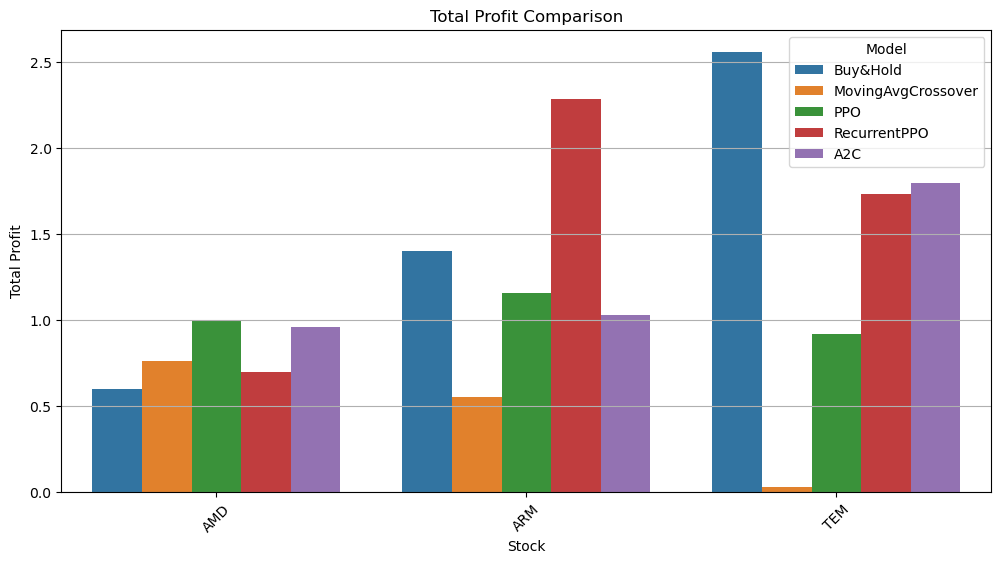

In [ ]:
# Set up another figure for total profit
plt.figure(figsize=(12, 6), dpi=100)

# Plot total profit comparison
sns.barplot(data=results_df, x="Stock", y="Total Profit", hue="Model")
plt.title("Total Profit Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Profit")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

#plt.savefig("total_profit_comparison.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_sharpe_ratio(df, risk_free_rate=0.02):
    daily_returns = df['Close'].pct_change().dropna()
    excess_returns = daily_returns - (risk_free_rate / 252)  # Assuming 252 trading days
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

def compute_max_drawdown(df):
    cumulative_returns = (1 + df['Close'].pct_change().dropna()).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

def compute_win_rate(df, model_positions):
    daily_returns = df['Close'].pct_change().dropna()
    wins = (daily_returns > 0).sum()
    total_trades = (model_positions.diff().fillna(0) != 0).sum()
    win_rate = wins / total_trades if total_trades > 0 else 0
    return win_rate

def run_tests():
    stocks = ['AMD', 'ARM', 'TEM']
    models = ['PPO', 'RecurrentPPO', 'A2C']
    results = []

    for stock in stocks:
        df = load_data(stock)

        # Buy & Hold Strategy
        buy_hold_reward, buy_hold_profit = compute_buy_hold(df)
        results.append({'Stock': stock, 'Model': 'Buy&Hold', 'Total Rewards': buy_hold_reward, 'Total Profit': buy_hold_profit,
                        'Sharpe Ratio': compute_sharpe_ratio(df), 'Max Drawdown': compute_max_drawdown(df), 'Win Rate': 1.0})

        # Moving Average Crossover Strategy
        mac_reward, mac_profit = moving_average_crossover(df)
        mac_win_rate = compute_win_rate(df, df['Position'])
        results.append({'Stock': stock, 'Model': 'MovingAvgCrossover', 'Total Rewards': mac_reward, 'Total Profit': mac_profit,
                        'Sharpe Ratio': compute_sharpe_ratio(df), 'Max Drawdown': compute_max_drawdown(df), 'Win Rate': mac_win_rate})

        # Reinforcement Learning Models
        for model in models:
            info = make_pred(df, model)
            if info:
                results.append({'Stock': stock, 'Model': model, 'Total Rewards': info.get('total_reward', 0), 'Total Profit': info.get('total_profit', 0),
                                'Sharpe Ratio': compute_sharpe_ratio(df), 'Max Drawdown': compute_max_drawdown(df), 'Win Rate': np.nan})

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Run the tests
results_df = run_tests()

# Set up the figure for Sharpe Ratio Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Sharpe Ratio", hue="Model")
plt.title("Sharpe Ratio Comparison")
plt.xlabel("Stock")
plt.ylabel("Sharpe Ratio")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Set up the figure for Max Drawdown Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Max Drawdown", hue="Model")
plt.title("Max Drawdown Comparison")
plt.xlabel("Stock")
plt.ylabel("Max Drawdown")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Set up the figure for Win Rate Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Win Rate", hue="Model")
plt.title("Win Rate Comparison")
plt.xlabel("Stock")
plt.ylabel("Win Rate")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()